## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import math
import os

### Read data into DFs

In [2]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
test_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,pred
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [4]:
#strip whitespace

def data_to_str(df):
    """
    Strip leading/trailing spaces from all string (object) columns.
    """
    str_cols = df.select_dtypes(include=['object']).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

# Apply to both train and test
train_df = data_to_str(train_df)
test_df = data_to_str(test_df)

In [5]:
train_df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [6]:
test_df['workclass'].unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [7]:
#fix test set label: removing the period --- <=50K. → <=50K

test_df['pred'].value_counts()   # before

# Remove trailing period if present
test_df['pred'] = test_df['pred'].str.rstrip('.')

test_df['pred'].value_counts()   # after

pred
<=50K    12435
>50K      3846
Name: count, dtype: int64

In [8]:
#turn "?" into missing values in both sets

train_df.replace("?", pd.NA, inplace=True)

In [9]:
# Convert "?" to missing values (NaN) in both dataframes
train_df.replace("?", np.nan, inplace=True)
test_df.replace("?", np.nan, inplace=True)

# Sanity check: how many missing values per column?
train_df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
pred                 0
dtype: int64

In [10]:
test_df.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
pred                0
dtype: int64

In [11]:
# Before dropping
print("Train shape before dropping NaN:", train_df.shape)
print("Test shape before dropping NaN:", test_df.shape)

Train shape before dropping NaN: (32561, 15)
Test shape before dropping NaN: (16281, 15)


In [12]:
# Drop rows with any NaN
train_df = train_df.dropna()
test_df = test_df.dropna()

# After dropping
print("Train shape after dropping NaN:", train_df.shape)
print("Test shape after dropping NaN:", test_df.shape)

Train shape after dropping NaN: (30162, 15)
Test shape after dropping NaN: (15060, 15)


In [13]:
#convert numeric columns to integer types

def data_to_int32(df):
    """
    Convert known numeric columns to int32 (or Int64 if you want to allow NaN).
    """
    int_cols = [
        'age',
        'fnlwgt',
        'education-num',
        'capital-gain',
        'capital-loss',
        'hours-per-week'
    ]
    for col in int_cols:
        df[col] = df[col].astype('int32')
    return df

train_df = data_to_int32(train_df)
test_df = data_to_int32(test_df)

train_df.dtypes

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
pred              object
dtype: object

In [14]:
#removing duplicate rows

print("Train duplicates:", train_df.duplicated().sum())
print("Test duplicates:", test_df.duplicated().sum())

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

print("Train shape after dedup:", train_df.shape)
print("Test shape after dedup:", test_df.shape)

Train duplicates: 23
Test duplicates: 5
Train shape after dedup: (30139, 15)
Test shape after dedup: (15055, 15)


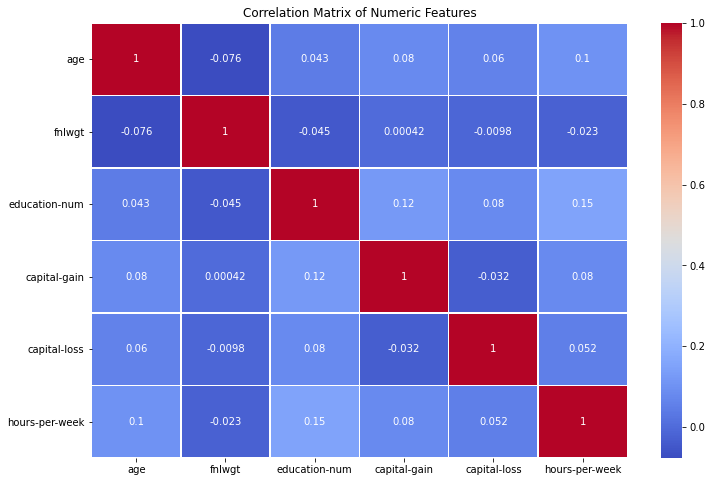

In [15]:
#OHE for numerical features only

# Select numeric columns only
numeric_df = train_df.select_dtypes(include=['int32', 'int64', 'float64'])

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

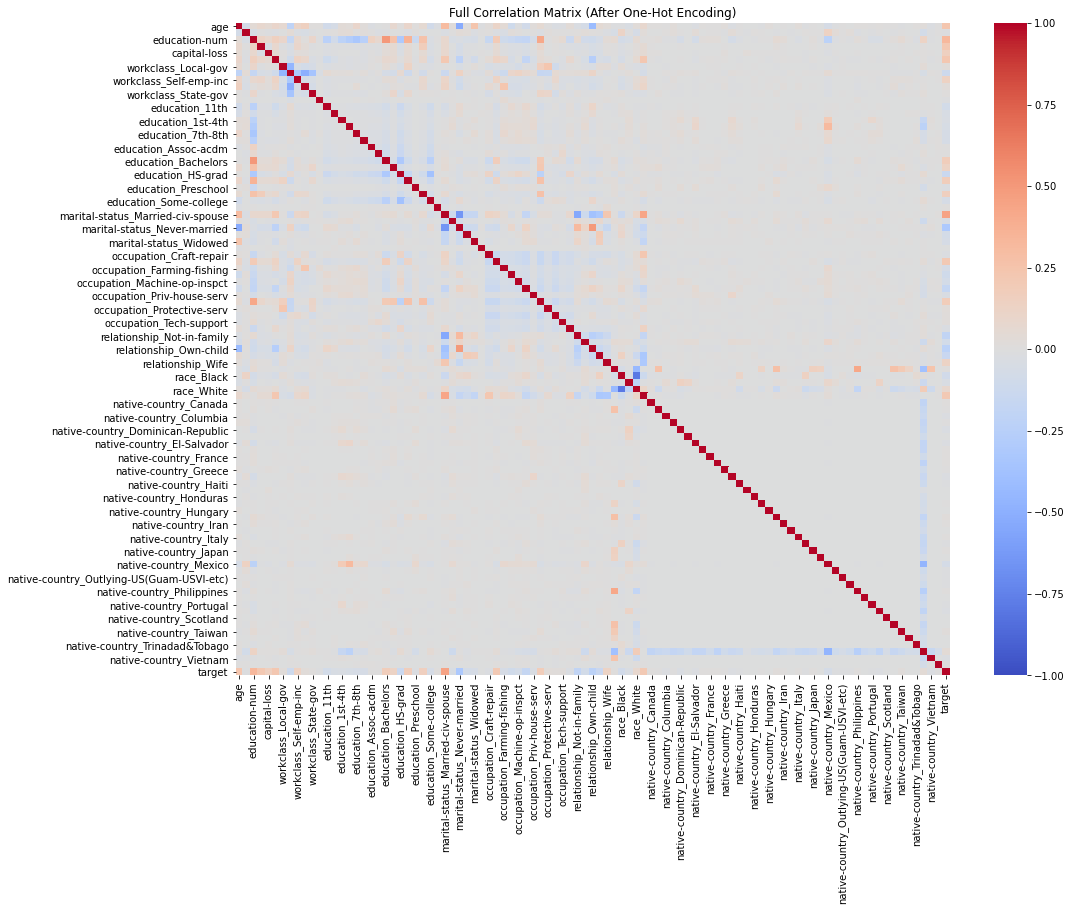

In [16]:
#OHE for correlation matrix

# One-hot encode categorical features
encoded_df = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)

# Add encoded label for correlation study
encoded_df['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

corr = encoded_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Full Correlation Matrix (After One-Hot Encoding)")
plt.show()

In [17]:
print(corr)

                                     age    fnlwgt  education-num  \
age                             1.000000 -0.076279       0.043203   
fnlwgt                         -0.076279  1.000000      -0.045199   
education-num                   0.043203 -0.045199       1.000000   
capital-gain                    0.080162  0.000420       0.124455   
capital-loss                    0.060141 -0.009755       0.079613   
...                                  ...       ...            ...   
native-country_Trinadad&Tobago  0.007865 -0.000413      -0.017161   
native-country_United-States    0.015774 -0.083044       0.126374   
native-country_Vietnam         -0.017800 -0.010765      -0.010985   
native-country_Yugoslavia       0.000651  0.005708      -0.001673   
target                          0.242017 -0.008992       0.335413   

                                capital-gain  capital-loss  hours-per-week  \
age                                 0.080162      0.060141        0.101348   
fnlwgt         

In [18]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)

corr  # or print(corr)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,target
age,1.000000,-0.076279,0.043203,0.080162,0.060141,0.101348,0.068222,-0.210427,0.111055,0.150372,0.014754,0.015340,-0.087856,-0.055099,0.034591,0.024436,0.095923,0.017552,-0.016362,-0.003168,0.006877,0.074273,0.010709,0.096530,0.009633,0.059848,-0.093624,-0.015635,0.308196,0.015800,-0.524021,0.013049,0.246996,-0.010818,0.015897,0.111487,0.039980,-0.104186,-0.014932,-0.093270,0.020022,0.060705,0.005444,-0.029446,-0.018277,0.032349,-0.023759,-0.069409,-0.420651,0.049758,0.024525,-0.007847,-0.014038,-0.032393,0.027281,0.081827,0.013966,0.013738,0.002949,0.029881,-0.003627,-0.004555,-0.016353,0.011464,0.003300,0.006235,0.018352,-0.019843,0.000301,-0.002826,-0.006244,-0.009905,0.017311,-0.001545,0.003959,-0.004264,0.029129,-0.010379,0.001254,-0.005056,-0.057023,-0.013873,0.000447,-0.006190,0.007926,0.010577,0.001052,0.007823,0.000019,0.001910,-0.007895,-0.004950,0.007865,0.015774,-0.017800,0.000651,0.242017
fnlwgt,-0.076279,1.000000,-0.045199,0.000420,-0.009755,-0.023033,-0.003524,0.046515,-0.025507,-0.041313,-0.010669,-0.003168,0.006242,0.011294,0.037442,0.042765,0.001822,0.017216,0.005319,-0.017441,-0.008149,-0.001076,-0.002711,-0.022289,0.017216,-0.005346,-0.003020,-0.000909,-0.028899,0.004876,0.038424,0.029977,-0.022958,0.004193,0.009647,-0.019557,-0.033809,0.028233,0.013415,-0.004565,0.007127,-0.017802,0.017631,0.003989,0.003169,0.000858,0.010167,0.026767,0.014609,0.003310,-0.017407,-0.050203,0.118627,0.004972,-0.058997,0.025602,-0.004817,-0.004951,0.015586,0.030516,0.001487,-0.000925,0.035135,-0.003292,0.001582,0.000673,-0.013608,0.033529,0.006882,-0.008827,0.011596,0.007795,-0.001830,-0.011608,-0.002932,-0.013840,-0.003066,0.011831,0.000090,0.006130,0.136509,0.033010,0.002998,0.026078,-0.018964,-0.002248,-0.014025,0.007123,-0.003056,-0.010602,0.001615,-0.001242,-0.000413,-0.083044,-0.010765,0.005708,-0.008992
educatio

In [19]:
# Convert to pairs of correlations
corr_pairs = corr.unstack()

# Sort by absolute value, descending
corr_pairs_sorted = corr_pairs.abs().sort_values(ascending=False)
corr_pairs_sorted = corr_pairs_sorted[corr_pairs_sorted < 0.999]  

corr_pairs_sorted

race_Black                                 race_White                                   0.794852
race_White                                 race_Black                                   0.794852
marital-status_Married-civ-spouse          marital-status_Never-married                 0.644693
marital-status_Never-married               marital-status_Married-civ-spouse            0.644693
relationship_Not-in-family                 marital-status_Married-civ-spouse            0.546279
marital-status_Married-civ-spouse          relationship_Not-in-family                   0.546279
age                                        marital-status_Never-married                 0.524021
marital-status_Never-married               age                                          0.524021
education-num                              education_Bachelors                          0.506038
education_Bachelors                        education-num                                0.506038
workclass_Private             

In [20]:
high_corr = corr_pairs_sorted[corr_pairs_sorted > 0.5]
high_corr

race_Black                         race_White                           0.794852
race_White                         race_Black                           0.794852
marital-status_Married-civ-spouse  marital-status_Never-married         0.644693
marital-status_Never-married       marital-status_Married-civ-spouse    0.644693
relationship_Not-in-family         marital-status_Married-civ-spouse    0.546279
marital-status_Married-civ-spouse  relationship_Not-in-family           0.546279
age                                marital-status_Never-married         0.524021
marital-status_Never-married       age                                  0.524021
education-num                      education_Bachelors                  0.506038
education_Bachelors                education-num                        0.506038
workclass_Private                  workclass_Self-emp-not-inc           0.505470
workclass_Self-emp-not-inc         workclass_Private                    0.505470
dtype: float64

In [21]:
# Convert pred to binary
train_df['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

# One-hot encode ALL features except target
encoded = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)

# Compute correlation with target only
corr_target = encoded.corr()['target'].sort_values(ascending=False)

corr_target

target                                       1.000000
marital-status_Married-civ-spouse            0.445329
education-num                                0.335413
age                                          0.242017
hours-per-week                               0.229435
capital-gain                                 0.221204
sex_Male                                     0.216668
occupation_Exec-managerial                   0.213467
occupation_Prof-specialty                    0.181471
education_Bachelors                          0.178902
education_Masters                            0.174234
education_Prof-school                        0.156468
capital-loss                                 0.150026
workclass_Self-emp-inc                       0.137623
education_Doctorate                          0.129158
relationship_Wife                            0.125092
race_White                                   0.084781
native-country_United-States                 0.039940
workclass_Local-gov         

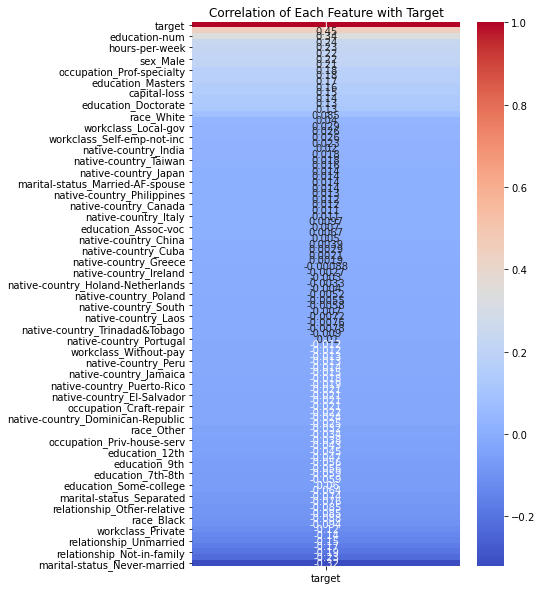

In [22]:
plt.figure(figsize=(6,10))
sns.heatmap(corr_target.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation of Each Feature with Target")
plt.show()

In [23]:
encoded = pd.get_dummies(train_df.drop(columns=['pred']), drop_first=True)

encoded['target'] = train_df['pred'].apply(lambda x: 1 if x == '>50K' else 0)

encoded['occupation_Sales'].corr(encoded['target'])

0.01835028971269156

In [24]:
# Remove native-country
encoded_filtered = encoded.drop(columns=[col for col in encoded.columns 
                                         if col.startswith("native-country_")])

# Remove numeric columns
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                'capital-loss', 'hours-per-week', 'target']  
encoded_filtered = encoded_filtered.drop(columns=[col for col in numeric_cols 
                                                  if col in encoded_filtered.columns])

# Compute correlation with target only (SORTED DESCENDING)
corr_target_only = encoded_filtered.join(train_df['target']) \
                                   .corr()['target'] \
                                   .sort_values(ascending=False)


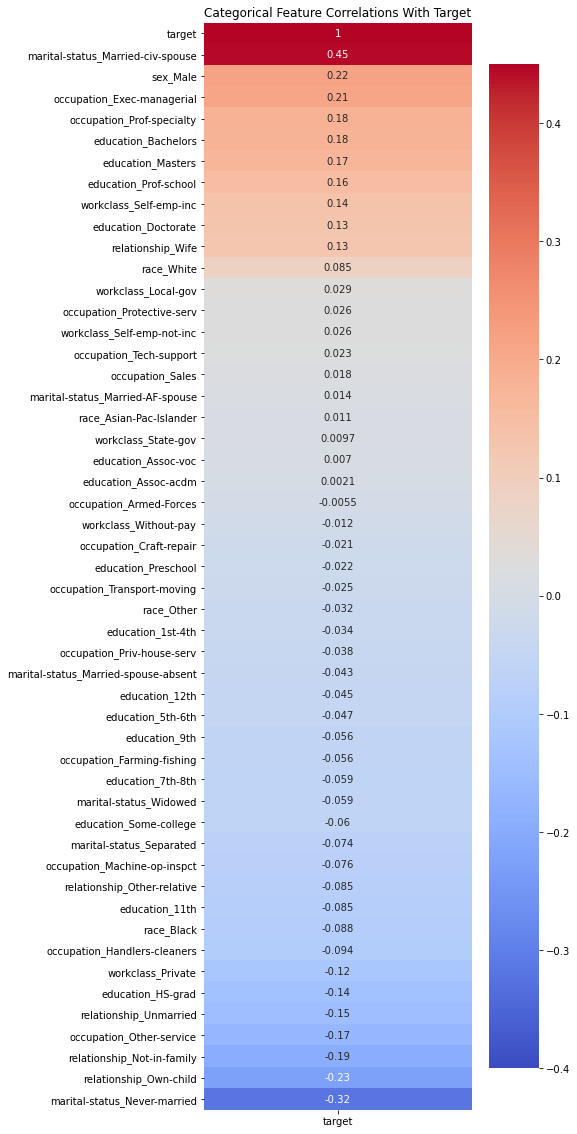

In [25]:
plt.figure(figsize=(6, 20))
sns.heatmap(corr_target_only.to_frame(),
            annot=True,
            cmap='coolwarm',
            vmin=-0.4,
            vmax=0.45)
plt.title("Categorical Feature Correlations With Target")
plt.show()

In [26]:
# Full correlation matrix among remaining categorical dummy columns
cat_corr_matrix = encoded_filtered.corr()

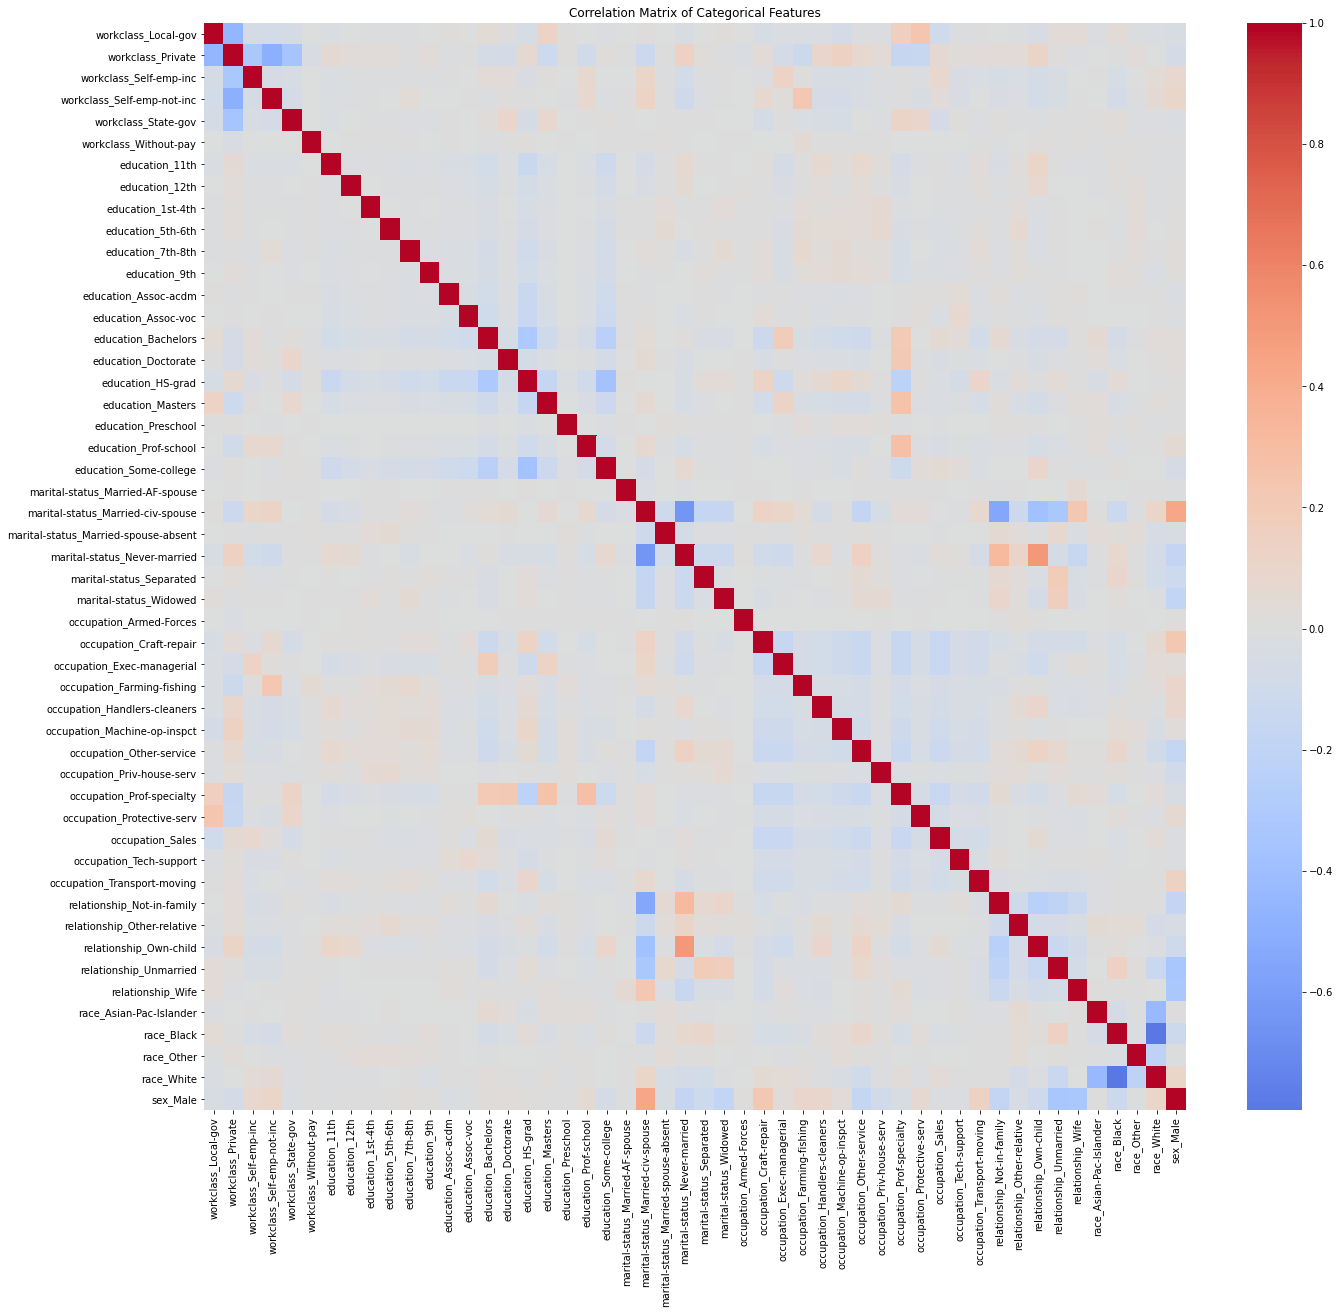

In [27]:
plt.figure(figsize=(22, 20))
sns.heatmap(cat_corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Categorical Features")
plt.show()